In [20]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('country_product_export_2019.zip', index_col=None)
df.head()

In [4]:
pivot = df.pivot_table(columns='name_country', index='name_product', values='export_value', aggfunc=np.mean, fill_value=0)
pivot.tail()

In [114]:
pivot[pivot.index.str.contains('Cocoa', case=False)]

name_country,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,...,United Republic of Tanzania,Uruguay,Uzbekistan,Vanuatu,Venezuela,Viet Nam,Wallis and Futuna Islands,Yemen,Zambia,Zimbabwe
name_product,,,,,,,,,,,,,,,,,,,,,
"Chocolate & other food preparations containing cocoa; in blocks, slabs or bars weighing more than 2kg or in liquid, paste, powder, granular or other bulk form in containers or immediate packings, content exceeding 2kg",0.000,0.073,0.024,2.444,0.255,0.000,0.000,0.000,8321.041,8.030,...,0.464,27.568,45.244,0.000,229.310,2172.361,0.0,0.000,38.832,15.073
"Chocolate and other food preparations containing cocoa; in blocks, slabs or bars, (not filled), weighing 2kg or less",0.000,139.310,309.091,0.000,0.000,0.000,0.000,0.706,6891.399,401.128,...,0.777,59.501,550.290,7.976,170.738,6486.347,0.0,0.000,14.139,10.967
"Chocolate and other food preparations containing cocoa; in blocks, slabs or bars, filled, weighing 2kg or less",0.000,129.333,92.256,0.000,0.000,0.000,0.000,7.770,2275.419,340.159,...,153.469,10.393,185.364,0.000,3.041,609.335,0.0,0.000,0.000,23.338
Chocolate and other food preparations containing cocoa; n.e.s. in chapter 18,0.141,243.478,846.948,7.325,0.071,5.186,0.038,19.845,74668.134,17379.221,...,0.132,1570.879,6255.785,0.000,648.246,13126.544,0.0,0.000,2129.624,35.548
"Cocoa beans; whole or broken, raw or roasted",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,133.129,13.461,...,24233.873,83.033,0.000,4324.091,43330.943,5212.605,0.0,0.000,0.000,0.000
"Cocoa; butter, fat and oil",0.000,0.000,12007.560,0.000,0.000,0.000,0.000,0.000,2.272,11.213,...,0.320,3.155,0.000,0.000,4835.981,26.948,0.0,0.000,0.000,0.000
"Cocoa; paste, not defatted",0.000,0.000,68.249,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,260.026,646.516,0.0,0.000,0.000,0.000
"Cocoa; paste, wholly or partly defatted",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.173,2.531,...,0.000,0.000,0.000,0.000,0.026,0.000,0.0,0.000,0.000,0.000
"Cocoa; powder, containing added sugar or other sweetening matter",0.000,0.020,0.529,7.874,0.000,2.192,0.000,0.000,621.664,1.053,...,0.147,2.838,0.000,0.000,2.992,371.072,0.0,0.000,64.641,0.018


<Axes: xlabel='name_country'>

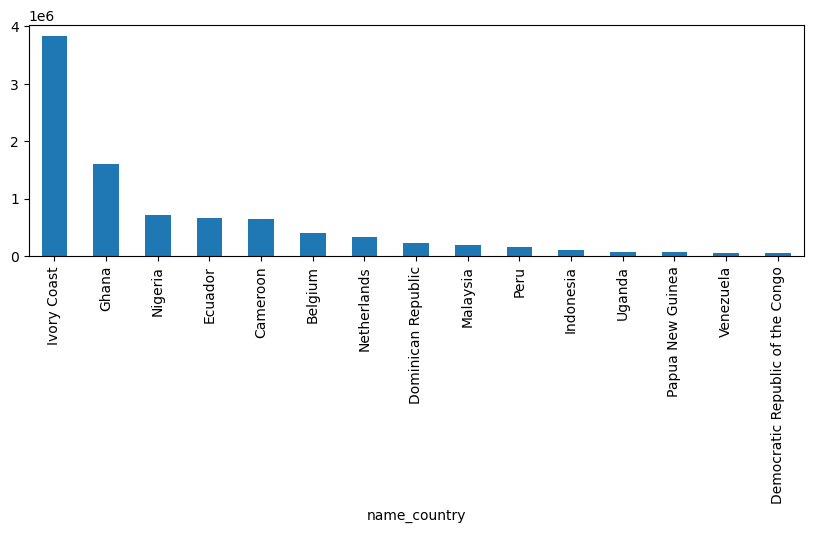

In [116]:
pivot.loc['Cocoa beans; whole or broken, raw or roasted', :].sort_values(ascending=False).head(15).plot(kind='bar', figsize=(10, 3))

# Create M matrix

$$\text{RCA}_{cp} = \frac{x_{cp} / x_p}{x_c / x}$$

$$ M_{cp} = \text{RCA}_{cp} > 1

In [28]:
x_p = pivot.sum()
x_c = pivot.sum(axis=1)
x = pivot.sum().sum()

In [35]:
rca = (pivot / x_p).div(x_c / x, axis=0)

In [37]:
M = np.heaviside(rca - 1, 0)

## Create product space adjacency matrix

between i and j at time t: 
$$ \phi_{i,j} = \min\left[ P(RCAx_{i} | RCAx{j}), P(RCAx_{j} | RCAx{i}) \right]$$

, where, empirically:

$$ P(RCAx_{i} | RCAx_{j}) = \frac{\# (RCAx_{i} \& RCAx_{j})}{\# RCA_{j}} $$

So, using M, we have

$$P(RCAx_{p} | RCAx_{p'})  = \frac{\sum_c M_{cp} * M_{cp'} }{ \sum_c M_{cp'} }$$

In [38]:
RCA_conditional = M.dot(M.transpose()) / np.diag(M.dot(M.transpose()))

phi = pd.concat([RCA_conditional, RCA_conditional.transpose()]).groupby(level=0).min()

In [45]:
# make list
phi_list = phi.stack()
phi_list.sort_values(ascending=False, inplace=True)

# remove diagonal
phi_list = phi_list[phi_list.index.get_level_values(0) != phi_list.index.get_level_values(1)]

In [81]:
phi_list.head(10)

name_product                                                                                          name_product                                                                                                                                            
Cereal pellets; of cereals other than wheat                                                           Mosses and lichens; of a kind suitable for bouquets or ornamental purposes, fresh, dried, dyed, bleached, impregnated or otherwise prepared                 1.0
                                                                                                      Asbestos-cement, cellulose fibre-cement articles or the like; tubes, pipes and tube or pipe fittings                                                        1.0
                                                                                                      Photographic film; for colour photography (polychrome), in rolls, sensitised, unexposed, of a width not exceeding 16mm 

In [80]:
phi_list[75:100]

name_product                                                                                                                                                                name_product                                                                                                                                                             
Skirts and divided skirts; women's or girls', of synthetic fibres (not knitted or crocheted)                                                                                Blouses, shirts and shirt-blouses; women's or girls', of man-made fibres (not knitted or crocheted)                                                                          0.815789
Blouses, shirts and shirt-blouses; women's or girls', of man-made fibres (not knitted or crocheted)                                                                         Skirts and divided skirts; women's or girls', of synthetic fibres (not knitted or crocheted)                                        

# Country - product density

$$ d^c_j = \frac{\sum_i M_{ci} \phi_{ij}}{\sum_i \phi_{ij}}

In [145]:
UK_products = M[M['United Kingdom'] == 1].index

In [146]:
proximity_to_UK = pd.DataFrame(index=phi.index, columns=['proximity_to_UK'])

In [147]:
proximity_to_UK

,proximity_to_UK
name_product,
"Abrasive powder or grain; natural or artificial, on a base of materials n.e.s. in heading no. 6805, whether or not cut to shape or sewn or otherwise made up",NaN
"Abrasive powder or grain; natural or artificial, on a base of paper or paperboard only, whether or not cut to shape or sewn or otherwise made up",NaN
"Abrasive powder or grain; natural or artificial, on a base of woven textile fabric only, whether or not cut to shape or sewn or otherwise made up",NaN
"Acetals and hemiacetals; whether or not with other oxygen function, and their halogenated, sulphonated, nitrated or nitrosated derivatives",NaN
Acid oils from refining,NaN
...,...
"Zinc; unwrought, alloys",NaN
Zinc; waste and scrap,NaN
Zirconium ores and concentrates,NaN


In [148]:
def calc_proximity(prod, UK_products, phi):
    proximity = phi.loc[prod, UK_products].sum() / phi.loc[prod, :].sum()
    return proximity

In [149]:
for product in proximity_to_UK.index:
    proximity_to_UK.loc[product, 'proximity_to_UK'] = calc_proximity(product, UK_products, phi)

In [150]:
proximity_to_UK.sort_values(by='proximity_to_UK', ascending=False, inplace=True)

In [151]:
proximity_to_UK

,proximity_to_UK
name_product,
"Meat; of sheep (including lamb), cuts with bone in (excluding carcasses and half-carcasses), fresh or chilled",0.596082
"Diamonds; whether or not worked, but not mounted or set, unsorted",0.538228
Heterocyclic compounds; lactams; other than 6-hexanelactam (epsilon caprolactam),0.519061
Anti-knock preparations; based on lead compounds,0.518209
Spices; fennel or juniper seeds,0.508563
...,...
"Amino-naphthols and other amino-phenols; their ethers and esters, (other than those containing more than one kind of oxygen function), aminohydroxynaphthalenesulphonic acids and their salts",0.17897
Monophenols; naphthols and their salts,0.177568
"Ties, bow ties and cravats; of man-made fibres (not knitted or crocheted)",0.177185


In [6]:
import complexity

In [82]:
M, eci, eci_list, pci, pci_list = complexity.pivot_to_eci_pci(pivot)

In [155]:
proximity_to_UK = proximity_to_UK.loc[pivot.index]

In [162]:
proximity_to_UK['pci'] = -pci

In [163]:
proximity_to_UK.sort_values('pci')

,proximity_to_UK,pci
name_product,,
Gum Arabic,0.287413,-0.049882
"Wood; keruing, ramin, kapur, teak, jongkong, merbau, jelutong, and kempas; in the rough, whether or not stripped of bark or sapwood, or roughly squared, untreated",0.268879,-0.044954
"Oil seeds; sesamum seeds, whether or not broken",0.245318,-0.044835
"Ground-nuts; shelled, not roasted or otherwise cooked, whether or not broken",0.258148,-0.042262
"Rubber; natural (excluding latex, technically specified natural rubber and smoked sheets), in primary forms or in plates, sheets or strip",0.211417,-0.041860
...,...,...
Surveying equipment; theodolites and tacheometers,0.309101,0.039356
"Photographic plates and film; exposed and developed, (other than cinematographic film, microfilm or that for offset reproduction)",0.28582,0.040002
"Plastics; plates, sheets, film, foil and strip, of cellulose acetate, non-cellular and not reinforced, laminated, supported or similarly combined with other materials",0.229763,0.045220


In [165]:
import plotly.express as px

In [166]:
# interactive plot with names on hover
fig = px.scatter(proximity_to_UK, x='proximity_to_UK', y='pci', hover_name=proximity_to_UK.index)
fig.show()

Compare with https://green-transition-navigator.org/

# Ubiquity and diversity

In [26]:
u = M.sum(axis=1).sort_values(ascending=False)
d = M.sum(axis=0).sort_values(ascending=False)

In [176]:
d

name_country
China                2172.0
Italy                2025.0
Germany              1779.0
Spain                1751.0
France, Monaco       1558.0
                      ...  
Chad                   18.0
Cayman Islands         17.0
Iraq                   16.0
Equatorial Guinea      15.0
South Sudan            13.0
Length: 225, dtype: float64

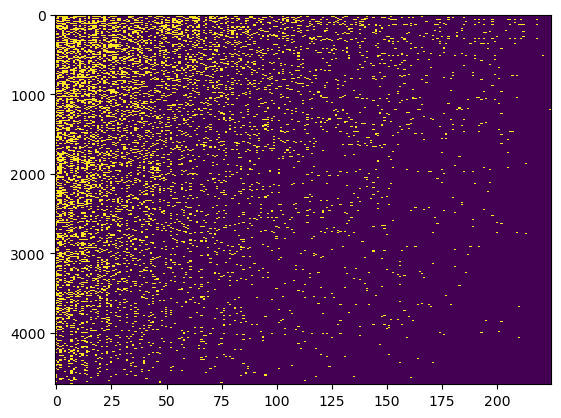

In [50]:
plt.imshow(M.loc[u.index, d.index], interpolation='none', aspect='auto')